# EDA

In this EDA, the study dataset are examined in more detail. The goal is to understand the data and the structure of it better.


In [7]:
from textblob_de import TextBlobDE
import nbformat
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 
from functions import *
from gensim.utils import simple_preprocess
from globalvars import *
from IPython.display import display
from IPython.display import Markdown as md
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pandas_profiling import ProfileReport
import contractions
import gensim
import kaleido
import nltk
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
import plotly.io as pio
import re
import spacy
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

## download nlp language package
#!python -m spacy download de_core_news_lg


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dom/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/dom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
!pip install spacy[de_core_news_lg] 

zsh:1: no matches found: spacy[de_core_news_lg]


### Load Data

In [9]:
## Import dataframe
filelocation = 'data/DataClean'
df = pd.read_feather(filelocation)

## load config file
config = pd.read_excel('config/config.xlsx',sheet_name='fragecodes')

invites_month = pd.read_excel('config/config.xlsx',sheet_name='invites')
#invites_month['yearmonth']= invites_month['yearmonth'].dt.to_period('M')


In [72]:
#df.info()

In [73]:
#df[df['u_fahrausweis']=='Normales Billett'].sort_values('u_date',ascending=True)

## EDA

Possiblity to filter on a specific timerange. The filter is applied the whole EDA.

In [10]:
startdate = '2019-01-01'
enddate = '2022-12-31'

# Apply time selection for all DataFrames
df= df[(df['u_date'] > startdate) & (df['u_date'] < enddate)]

### Overview

#### General DataFrame Overview

In [12]:
df = df.sort_values("u_date",ascending=False)

In [13]:
df.head(5)

,participant_id,u_date,Kommentar,wime_personal,wime_komfort,wime_sauberkeit,wime_puenktlich,wime_platzangebot,wime_gesamtzuf,wime_preis_leistung,...,ft_vm_kurz,ft_zielort_uic,fg_abfahrt,fg_ankunft,fg_startort_uic,fg_zielort_uic,fg_startort,fg_zielort,ft_startort,ft_zielort
239930,604462,2022-12-30,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
239893,604418,2022-12-30,die befragung trifft einen ausnahme tag - feri...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,IR,8500218,2023-01-04 11:32:00,2023-01-04 11:55:00,8500309,8500218,Brugg AG,Olten,Brugg AG,Olten
239915,604443,2022-12-30,Free W-Lan in allen Zügen (evtl auch nur für G...,100.0,25.0,75.0,100.0,100.0,100.0,75.0,...,ICE,8500023,2023-01-04 14:12:00,2023-01-04 16:49:00,8507372,8500023,Wengen,Liestal,Interlaken Ost,Liestal
239914,604442,2022-12-30,<NA>,100.0,75.0,75.0,100.0,100.0,100.0,75.0,...,IC,8507000,2023-01-04 08:05:00,2023-01-04 08:52:00,8507493,8507000,Interlaken West,Bern,Interlaken West,Bern
239932,604464,2022-12-30,Bitte nicht zufest heizen im Zug. Sehr oft zu ...,NaN,75.0,75.0,50.0,100.0,100.0,75.0,...,S,8503000,2023-01-04 07:37:00,2023-01-04 07:58:00,8503527,8503000,Buchs-Dällikon,Zürich HB,Buchs-Dällikon,Zürich HB


In [14]:
df.shape

(239808, 41)

In [15]:
## Add additional date columns for easier vizualization
df.insert(loc=2, column = 'year', value=df['u_date'].dt.year) #create additional year col for viz
df.insert(loc=3, column = 'month', value=df['u_date'].dt.month) #create additional month col for viz
df['yearmonth'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1)) #create additional yearmonth col for viz
#df['yearmonth']= df['u_date'].dt.to_period('M')

### TextData

In [16]:

df_text = df.dropna(subset=["Kommentar"])

#### Number of comments per month

In [17]:
df_text_counts = pd.DataFrame(df_text.groupby(['yearmonth'])['participant_id'].count()).reset_index()
df_participantstotals_counts = pd.DataFrame(df.groupby(['yearmonth'])['participant_id'].count()).reset_index()

In [18]:
# Merge Dataframes
df_counts_month = df_text_counts.merge(df_participantstotals_counts, on='yearmonth', how='left')
df_counts_month = df_counts_month.merge(invites_month, on='yearmonth', how='left') # join aount of invites
df_counts_month.rename(columns = {'participant_id_x':'Anzahl Befragte mit Kommentar','participant_id_y':'Anzahl Befragte'}, inplace = True)
df_counts_month['Kommentar Ratio in %'] = (df_counts_month['Anzahl Befragte mit Kommentar']/df_counts_month['Anzahl Befragte'])*100
df_counts_month['Rücklauf Ratio in %'] = (df_counts_month['Anzahl Befragte']/df_counts_month['Anzahl Einladungen'])*100

In [19]:
df_counts_month.describe()

,Anzahl Befragte mit Kommentar,Anzahl Befragte,Anzahl Einladungen,Kommentar Ratio in %,Rücklauf Ratio in %
count,46.000000,46.000000,45.000000,46.000000,45.000000
mean,1403.630435,5213.217391,77016.488889,26.740743,6.730296
std,502.688389,1731.805300,21586.490469,2.497949,0.891455
min,637.000000,2314.000000,42605.000000,22.506454,4.752712
25%,1004.750000,4044.000000,60439.000000,24.710122,6.199034
50%,1328.500000,5111.500000,71945.000000,26.068803,6.731562
75%,1746.500000,5960.500000,89940.000000,28.397626,7.162673
max,2698.000000,9898.000000,122993.000000,31.907954,9.891194


In [20]:
len(df)

239808

In [21]:
## plot settings
color_discrete_sequence = color_discrete_sequence #imported from globalvars.py
template = template ##imported from globalvars.py

In [22]:
df_counts_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 45
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   yearmonth                      46 non-null     datetime64[ns]
 1   Anzahl Befragte mit Kommentar  46 non-null     int64         
 2   Anzahl Befragte                46 non-null     int64         
 3   Anzahl Einladungen             45 non-null     float64       
 4   Kommentar Ratio in %           46 non-null     float64       
 5   Rücklauf Ratio in %            45 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 2.5 KB


In [23]:
fig = px.line(df_counts_month,
              x="yearmonth",
              y=['Anzahl Befragte mit Kommentar', 'Anzahl Befragte','Anzahl Einladungen'],
              color_discrete_sequence=color_discrete_sequence,
              template=template)

fig.update_layout(
    title="Anzahl Einladungen, Anzahl Befragungen & Anzahl Befragte mit Kommentar",
    yaxis_title='',
    xaxis_title='',
    width=1200, 
    height=600,
    legend_title="")

fig.update_traces(line_width=2)
fig.update_traces(patch={"line": {"dash": 'dot'}}, selector={"legendgroup": "Anzahl Einladungen"})

fig.update_yaxes(type="log") 

fig.add_vrect(
    x0="2020-03-01",
    x1="2020-05-31",
    line_width=0,
    fillcolor="#0B1F26",
    opacity=0.2,
    annotation_text="Pause",
    annotation_position="top left",
    annotation_font_size=10,
    annotation_font_color="#0B1F26",
)

fig.update_traces(connectgaps=False)

fig.show()

pio.write_image(fig,"images/fig-anteil_befragte_und_anzahl_kommentare.svg") #save fig as svg

In [24]:
fig = px.line(df_counts_month,
              x="yearmonth",
              y='Kommentar Ratio in %',
              color_discrete_sequence=color_discrete_sequence,
              template=template)
fig.update_layout(
    title="Anteil Befragte mit Kommentar",
    yaxis_title='Anteil in %',
    xaxis_title='Monat',
    width=1200, 
    height=600,
    )
fig.update_traces(line_width=2)
#fig.update_yaxes(range=(0,40))


# show legend for singel line plots
fig['data'][0]['showlegend'] = True
fig['data'][0]['name'] = 'Anteil Kommentare in %'

fig.update_yaxes(range=(21,35))

fig.show()

pio.write_image(fig,"images/fig-anteil-befragte-mit-kommentar.svg") #save fig as svg

In [25]:
df_counts_month.describe()

,Anzahl Befragte mit Kommentar,Anzahl Befragte,Anzahl Einladungen,Kommentar Ratio in %,Rücklauf Ratio in %
count,46.000000,46.000000,45.000000,46.000000,45.000000
mean,1403.630435,5213.217391,77016.488889,26.740743,6.730296
std,502.688389,1731.805300,21586.490469,2.497949,0.891455
min,637.000000,2314.000000,42605.000000,22.506454,4.752712
25%,1004.750000,4044.000000,60439.000000,24.710122,6.199034
50%,1328.500000,5111.500000,71945.000000,26.068803,6.731562
75%,1746.500000,5960.500000,89940.000000,28.397626,7.162673
max,2698.000000,9898.000000,122993.000000,31.907954,9.891194


#### Minimal, maximal and average length of Kommentar

In [26]:
## Add basic text features
df_text["Kommentar"] = remove_redundant_whitespaces(df_text["Kommentar"]) #note: imported function "remove_redundant_whitespaces"
df_text = add_basic_textfeatures(df_text,"Kommentar")

/var/folders/0q/zp8d2_c16z32wsh2hdjb9fch0000gn/T/ipykernel_55653/952732434.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
df_text_average_character_median_per_month = pd.DataFrame(df_text.groupby(['yearmonth'])['Kommentar_Character'].median()).reset_index()
df_text_average_character_mean_per_month = pd.DataFrame(df_text.groupby(['yearmonth'])['Kommentar_Character'].mean()).reset_index()

In [28]:
# Merge Dataframes
df_text_character_counts_month = df_text_average_character_median_per_month.merge(df_text_average_character_mean_per_month, on='yearmonth', how='left')
df_text_character_counts_month.rename(columns = {'Kommentar_Character_x':'Median Characters','Kommentar_Character_y':'Mittelwert Characters'}, inplace = True)

In [29]:
fig = px.line(df_text_character_counts_month,
              x="yearmonth",
              y=['Median Characters','Mittelwert Characters'],
              color_discrete_sequence=color_discrete_sequence,
              template=template)
fig.update_layout(
    title="Freitextkommentare: Characters-Median & Characters-Mittelwert in Vergleich",
    yaxis_title='Anzahl',
    xaxis_title='Monat',
    width=1200, 
    height=600,
    legend_title="")
fig.update_traces(line_width=2)
fig.update_yaxes(range=(81,200))



fig.show()

pio.write_image(fig,"images/fig-Characters-median-mittelwert.svg") #save fig as svg

In [30]:
fig = px.histogram(
    df_text,
    x="Kommentar_Character",
    range_x = [1,1500],
    title="Freitextkommentare: Häufigkeitsverteilung Länge der Kommentare (Characters)",
    color = "year",
    labels={'Kommentar_Character':'Anzahl Character'},
    color_discrete_sequence=color_discrete_sequence,
    width=1200, 
    height=600,
    template=template)
    
fig.update_layout(yaxis_title="Anzahl Kommentare")

# Overlay both histograms
fig.update_layout(barmode='overlay')

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.4)

fig.show()

pio.write_image(fig,"images/fig-character-hist.svg") #save fig as svg

In [31]:
df_text.describe()

,participant_id,year,month,wime_personal,wime_komfort,wime_sauberkeit,wime_puenktlich,wime_platzangebot,wime_gesamtzuf,wime_preis_leistung,wime_fahrplan,wime_oes_fahrt,S_alter,u_preis,Kommentar_Character,Kommentar_Tokens,Kommentar_Types,Kommentar_TTR
count,64567.000000,64567.000000,64567.000000,24070.000000,51747.000000,52460.000000,52636.000000,52943.000000,54953.000000,60595.000000,63692.000000,50245.000000,64413.000000,56408.000000,64567.000000,64567.000000,64567.000000,64484.000000
mean,373288.438180,2020.443137,6.792913,88.300789,74.395671,76.535350,86.937383,75.399171,78.809316,67.864831,78.415875,89.454672,52.130176,43.177030,172.690384,26.784890,23.888426,94.720758
std,179262.151418,1.208129,3.390651,19.783803,25.608631,23.196881,24.423167,30.249836,23.287770,29.182097,27.687758,16.154544,15.602395,269.681794,181.758559,28.565699,22.542537,6.896155
min,41305.000000,2019.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,33.333333
25%,334331.000000,2019.000000,4.000000,77.777778,55.555556,66.666667,77.777778,55.555556,75.000000,50.000000,66.666667,77.777778,41.000000,8.800000,58.000000,9.000000,8.000000,90.909091
50%,426441.000000,2020.000000,7.000000,100.000000,75.000000,77.777778,100.000000,88.888889,77.777778,75.000000,88.888889,100.000000,54.000000,17.400000,118.000000,18.000000,17.000000,100.000000
75%,516598.000000,2022.000000,10.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,64.000000,31.325000,217.000000,34.000000,32.000000,100.000000
max,604546.000000,2022.000000,12.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,98.000000,6300.000000,2047.000000,347.000000,230.000000,100.000000


In [95]:
#df_text.quantile(0.9) 

In [96]:
#df_text[df_text.year == 2019][df_text.Kommentar_Character == 199]

In [32]:
df_text

,participant_id,u_date,year,month,Kommentar,wime_personal,wime_komfort,wime_sauberkeit,wime_puenktlich,wime_platzangebot,...,fg_zielort_uic,fg_startort,fg_zielort,ft_startort,ft_zielort,yearmonth,Kommentar_Character,Kommentar_Tokens,Kommentar_Types,Kommentar_TTR
239893,604418,2022-12-30,2022,12,die befragung trifft einen ausnahme tag - feri...,100.000000,100.000000,100.000000,100.000000,100.000000,...,8500218,Brugg AG,Olten,Brugg AG,Olten,2022-12-01,89,14,14,100.000000
239915,604443,2022-12-30,2022,12,Free W-Lan in allen Zügen (evtl auch nur für G...,100.000000,25.000000,75.000000,100.000000,100.000000,...,8500023,Wengen,Liestal,Interlaken Ost,Liestal,2022-12-01,71,12,12,100.000000
239932,604464,2022-12-30,2022,12,Bitte nicht zufest heizen im Zug. Sehr oft zu ...,NaN,75.000000,75.000000,50.000000,100.000000,...,8503000,Buchs-Dällikon,Zürich HB,Buchs-Dällikon,Zürich HB,2022-12-01,78,15,15,100.000000
239994,604542,2022-12-30,2022,12,"Wir sind nicht nur nach Wattwil gefahren, sond...",100.000000,100.000000,75.000000,100.000000,100.000000,...,8506299,Rapperswil SG,Nesslau-Neu St. Johann,Rapperswil SG,Wattwil,2022-12-01,1316,198,165,83.333333
239951,604487,2022-12-30,2022,12,Mehr Abteile für Familien. Die Kinder rennen u...,NaN,75.000000,100.000000,100.000000,50.000000,...,8507100,Bern,Thun,Bern,Thun,2022-12-01,106,17,17,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,51699,2019-01-02,2019,1,Die Durchsage im Zug war falsch. Zuerst kam di...,77.777778,66.666667,66.666667,100.000000,33.333333,...,8504414,Zermatt,Lyss,Visp,Bern,2019-01-01,245,44,38,86.363636
966,51734,2019-01-02,2019,1,Deurlich zu wenig Platz fürs Gepäck (Koffer/Skis),100.000000,55.555556,100.000000,77.777778,0.000000,...,8506302,Bern,St. Gallen,Bern,St. Gallen,2019-01-01,49,7,7,100.000000
991,51766,2019-01-02,2019,1,"Preise senken, der Rest ist gut.",NaN,100.000000,100.000000,100.000000,100.000000,...,8503127,Zürich HB,Schwerzenbach ZH,Zürich HB,Schwerzenbach ZH,2019-01-01,32,6,6,100.000000
995,51773,2019-01-02,2019,1,Ich habe nie geschaft meine monates ABO zu ern...,NaN,88.888889,88.888889,100.000000,100.000000,...,8503003,Uerikon,Zürich Stadelhofen,Uerikon,Zürich Stadelhofen,2019-01-01,186,33,30,90.909091


- Median of 122 Characters per Comment (140 original Twitter length)
- Median of 19 Tokens per comment.
- Median TTR of 98.

In [33]:
satisfaction_codes = config[config['vartype'] == 'satisfaction']['fragecode'] #loading satisfaction codes from config
df_text['rating_selected_average'] = df_text[satisfaction_codes].mean(axis=1) #calculate mean ratings 

satisfaction_category = pd.cut(df_text['rating_selected_average'],bins=[0,25,50,75,100],labels=["<25 Punkte","25-50 Punkte","50-75 Punkte","75-100 Punkte"])
df_text.insert(49,"rating_selected_average_group",satisfaction_category)

satisfaction_category_spontan = pd.cut(df_text['wime_gesamtzuf'],bins=[0,25,50,75,100],labels=["<25 Punkte","25-50 Punkte","50-75 Punkte","75-100 Punkte"])
df_text.insert(50,"rating_wime_gesamtzuf_group",satisfaction_category_spontan)

In [34]:
# x and y given as array_like objects
fig = px.scatter(
    df_text,
    x='Kommentar_Character', 
    y='Kommentar_TTR',
    opacity = 1,
    color_discrete_sequence =color_discrete_sequence,
    color = "rating_selected_average_group",
    marginal_x='box',
    #color_continuous_scale=[(0,'red'), (0.75, 'orange'), (1,'green')]
                 )

fig.update_layout(
    title="Kommentarlänge und Type-Token Ratio im Vergleich mit Zufriedenheitsbewertung",
    yaxis_title='TTR in %',
    xaxis_title='Kommentarlänge in Character',
    width=1200, 
    height=600,
    legend_title="")

#fig.update_yaxes(range=(55,105))

fig.show()

pio.write_image(fig,"images/fig-Characters-TTR_scatter.svg") #save fig as svg

# Pandas Profiling TextData
profile = ProfileReport(
    df_text[
        [
            #"participant_id",
            #"u_date",
            "Kommentar",
            "Kommentar_Character",
            "Kommentar_TTR",
            "Kommentar_Tokens",
            "Kommentar_Types",
            'rating_selected_average',
        ]
    ],
    title="TextData",
    lazy=False,
    dark_mode=True,
)

profile.to_file("html/ProfilingTextData.html")


In [35]:
## Tokenize
from nltk.tokenize import word_tokenize
df_text['tokenized'] = df_text['Kommentar'].apply(word_tokenize)

In [36]:
## Lower
df_text['lower'] = df_text['tokenized'].apply(lambda x: [word.lower() for word in x])

In [37]:
## Removing Punctuations
punc = string.punctuation
df_text['no_punc'] = df_text['lower'].apply(lambda x: [word for word in x if word not in punc])

In [38]:
## Removing German Stopwords
stop_words = set(stopwords.words('german'))
df_text['stopwords_removed'] = df_text['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])

In [39]:
## Add string Version of lemmatized column to analyse sentiment
df_text['stopwords_removed_str'] = [' '.join(map(str,l)) for l in df_text['stopwords_removed']]

In [40]:
## Lemmatize
def lemmatize_words(texts, stop_words=stop_words):
    texts_out = []
    nlp = spacy.load('de_core_news_lg')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


# Apply function
df_text['lemmatized'] = lemmatize_words(df_text['stopwords_removed'])

In [41]:
## Add string Version of lemmatized column to analyse sentiment
df_text['lemma_str'] = [' '.join(map(str,l)) for l in df_text['lemmatized']]

In [42]:
## PoS Tagging
def pos_tagging(texts):
    tags = []
    for x in texts:
        blob = TextBlobDE(x)
        tags.append(blob.tags)
    return tags

# Apply function
df_text['pos_tagged'] = pos_tagging(df_text['lemma_str'])

In [43]:
############## Export ############## 
df_text = df_text.reset_index(drop=True)
df_text.to_feather('data/DataText') # store data in feather file

In [44]:
############## Import ############## 
filelocation = 'data/DataText'
df_text = pd.read_feather(filelocation)

### N-Grams

In [38]:
# create sub-dataframes for year specific plots
df_text_2019 = df_text[df_text['year']==2019] # FIlter on specific year (optional)
df_text_2020 = df_text[df_text['year']==2020] # FIlter on specific year (optional)
df_text_2021 = df_text[df_text['year']==2021] # FIlter on specific year (optional)
df_text_2022 = df_text[df_text['year']==2022] # FIlter on specific year (optional)

N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. In order to do this, we use scikit-learn’s CountVectorizer function.

In [39]:
dataframe_selected = df_text
label_plots = "All-Years"
dataframe_selected_len = len(dataframe_selected )

#### Unigrams

In [40]:
common_words = get_top_n_words(dataframe_selected['stopwords_removed_str'], 20) #NOTE: function is importet from other .py file

unigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])
unigrams['count_relative']=(unigrams['count']/dataframe_selected_len)*100
unigrams

,word,count,count_relative
0,zug,17614,27.280190
1,mehr,12481,19.330308
2,sbb,8631,13.367510
3,zürich,6085,9.424319
4,wäre,5870,9.091331
5,immer,5724,8.865210
6,klasse,5391,8.349466
7,app,5201,8.055198
8,züge,4625,7.163102
9,bahnhof,4320,6.690724


In [41]:
fig = px.bar(unigrams.sort_values('count_relative', ascending=True),
    x='count_relative', 
    y='word',
    opacity = 1,
    color_discrete_sequence =color_discrete_sequence
                 )

fig.update_layout(
    title="Top 20 - Unigrams ("+label_plots+")",
    yaxis_title='',
    xaxis_title='Relative Häufigkeit',
     xaxis=dict(ticksuffix="%"),
    width=400, 
    height=800,
    legend_title="")

#fig.update_yaxes(range=(55,105))

fig.show()

pio.write_image(fig,"images/fig-Unigrams-"+label_plots+"-barchart.svg") #save fig as svg

#### Bigrams

In [42]:
common_words_bigrams = get_top_n_bigram(dataframe_selected['stopwords_removed_str'], 20)

bigrams = pd.DataFrame(common_words_bigrams, columns = ['word' , 'count'])
bigrams['count_relative']=(bigrams['count']/dataframe_selected_len)*100
bigrams

,word,count,count_relative
0,sbb app,1479,2.290644
1,mehr platz,1034,1.601437
2,st gallen,908,1.406291
3,zürich hb,869,1.345889
4,wäre schön,615,0.952499
5,vielen dank,507,0.785231
6,viele leute,409,0.633451
7,minuten verspätung,392,0.607121
8,arth goldau,379,0.586987
9,wenig platz,368,0.569951


In [43]:
fig = px.bar(bigrams.sort_values('count_relative', ascending=True),
    x='count_relative', 
    y='word',
    opacity = 1,
    color_discrete_sequence =color_discrete_sequence
                 )

fig.update_layout(
    title="Top 20 - Bigrams ("+label_plots+")",
    yaxis_title='',
    xaxis_title='Relative Häufigkeit',
    xaxis=dict(ticksuffix="%"),
    width=400, 
    height=800,
    legend_title="")

#fig.update_yaxes(range=(55,105))

fig.show()

pio.write_image(fig,"images/fig-Bigrams-"+label_plots+"-barchart.svg") #save fig as svg

#### Trigrams

In [44]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [45]:
common_words_bigrams = get_top_n_bigram(dataframe_selected['stopwords_removed_str'], 20)

bigrams = pd.DataFrame(common_words_bigrams, columns = ['word' , 'count'])
bigrams['count_relative']=(bigrams['count']/dataframe_selected_len)*100
bigrams

,word,count,count_relative
0,sbb app,1479,2.290644
1,mehr platz,1034,1.601437
2,st gallen,908,1.406291
3,zürich hb,869,1.345889
4,wäre schön,615,0.952499
5,vielen dank,507,0.785231
6,viele leute,409,0.633451
7,minuten verspätung,392,0.607121
8,arth goldau,379,0.586987
9,wenig platz,368,0.569951


In [46]:
common_words_trigram = get_top_n_trigram(dataframe_selected['stopwords_removed_str'], 20)

trigrams = pd.DataFrame(common_words_trigram, columns = ['word' , 'count'])
trigrams['count_relative']=(trigrams['count']/dataframe_selected_len)*100
trigrams

,word,count,count_relative
0,sbb mobile app,156,0.241609
1,mehr platz gepäck,140,0.216829
2,mehr platz velos,89,0.137841
3,mehr klasse wagen,83,0.128549
4,lässt wünschen übrig,67,0.103768
5,darauf aufmerksam gemacht,64,0.099122
6,st gallen zürich,57,0.088280
7,wenig platz gepäck,55,0.085183
8,via sbb app,54,0.083634
9,mehr platz klasse,49,0.075890


In [47]:
fig = px.bar(trigrams.sort_values('count_relative', ascending=True),
    x='count_relative', 
    y='word',
    opacity = 1,
    color_discrete_sequence =color_discrete_sequence
                 )

fig.update_layout(
    title="Top 20 - Trigrams ("+label_plots+")",
    yaxis_title='',
    xaxis_title='Relative Häufigkeit',
    xaxis=dict(ticksuffix="%"),
    width=400, 
    height=800,
    legend_title="")

#fig.update_yaxes(range=(55,105))

fig.show()

pio.write_image(fig,"images/fig-Trigrams-"+label_plots+"-barchart.svg") #save fig as svg

### Satisfaction Data

In [48]:
#df_text.stopwords_removed_str.str.cat(sep='')

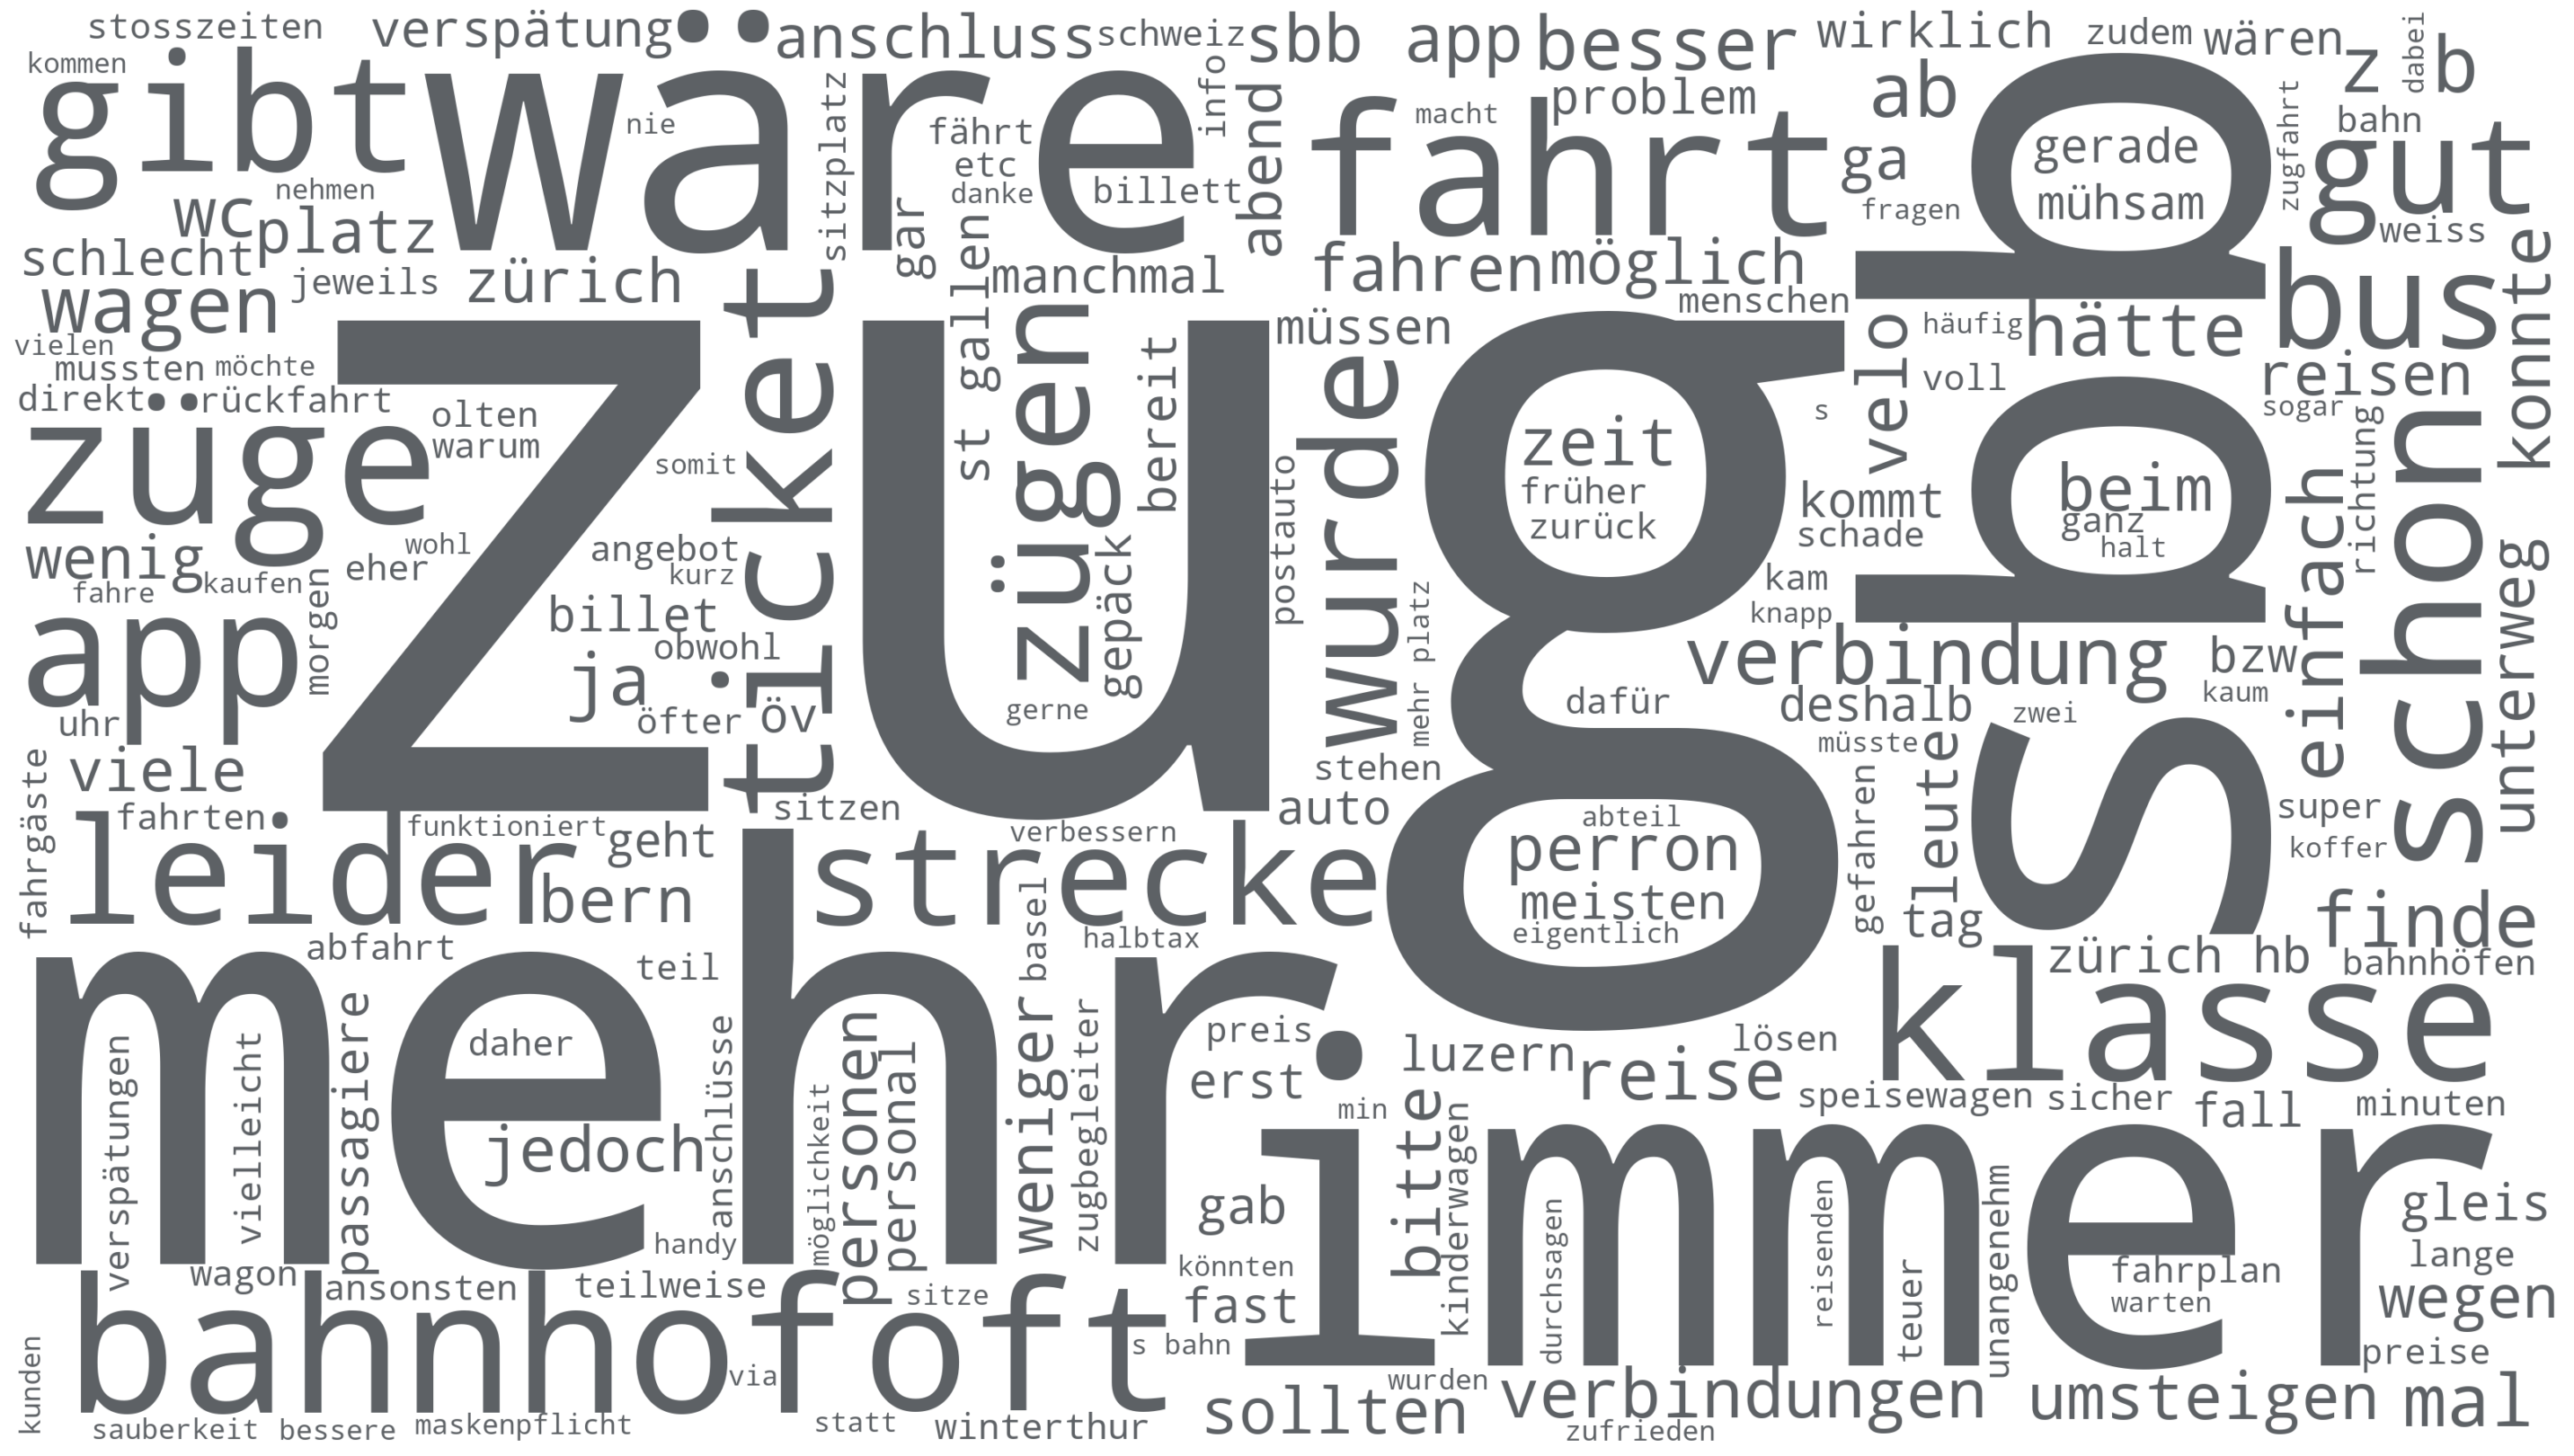

In [49]:
# Now let's generate a wordcloud for some reviews
font_color = "#5D6165"


wordcloud = WordCloud(width = 3200, height = 1800, 
                background_color ='white',
                color_func=lambda *args, **kwargs: font_color,
                min_font_size = 10).generate(df_text.stopwords_removed_str.str.cat())
  
# plot the WordCloud image                      
plt.figure(figsize = (32, 16), facecolor = None) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [50]:
#df_text.stopwords_removed_str.str.cat(sep='').replace(" ", "").replace("-", "").replace(".", "")

In [51]:
satisfaction_codes = config[config['vartype'] == 'satisfaction']['fragecode']

In [52]:
# Pandas Profiling Satisfaction Data
profile = ProfileReport(
    df[
        satisfaction_codes
    ],
    title="SatisfactionData",
    lazy=False,
    dark_mode=True,
)

profile.to_file("html/ProfilingSatisfactionData.html")


/Users/dom/Repos/github.com/DominikFin/nlp-satisfaction/venv/lib/python3.9/site-packages/multimethod/__init__.py:315: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 204.67it/s]


In [53]:
df_satisfaction = pd.melt(df, id_vars='yearmonth', value_vars=satisfaction_codes) #wide to long and only keep satisfaction questions
df_satisfaction = df_satisfaction.groupby(['yearmonth', 'variable'])[['value']].mean().reset_index() #groupy monthyear and variable

df_satisfaction_average = df_satisfaction.groupby(['yearmonth'])[['value']].mean().reset_index() #groupy monthyear to get overall average
df_satisfaction_average.insert(1,'variable',"Durchschnitt")

df_satisfaction = pd.concat([df_satisfaction,df_satisfaction_average],ignore_index=True).sort_values('yearmonth')

In [54]:
df_satisfaction

,yearmonth,variable,value
0,2019-01-01,wime_fahrplan,80.883316
8,2019-01-01,wime_sauberkeit,78.147641
7,2019-01-01,wime_puenktlich,89.092469
6,2019-01-01,wime_preis_leistung,72.451744
5,2019-01-01,wime_platzangebot,79.529696
...,...,...,...
411,2022-12-01,wime_preis_leistung,73.023355
412,2022-12-01,wime_puenktlich,88.158238
413,2022-12-01,wime_sauberkeit,77.505873
406,2022-12-01,wime_gesamtzuf,85.198908


In [55]:
fig = px.line(
    df_satisfaction,
    x="yearmonth",
    y="value",
    color="variable",
    color_discrete_sequence=color_discrete_sequence,
    template=template,
)

fig.update_layout(
    title="Zufriedenheit mit verschiedenen Aspekten im zeitlichen Verlauf",
    yaxis_title="Zufriedenheit",
    xaxis_title="",
    width=1200, 
    height=600,
    legend_title="",
)

fig.update_traces(line_width=2)
fig.update_yaxes(range=(62, 100))
fig.add_vrect(
    x0="2020-03-25",
    x1="2022-03-01",
    line_width=0,
    fillcolor="#0B1F26",
    opacity=0.1,
    annotation_text="COVID-19 Massnahmen",
    annotation_position="top right",
    annotation_font_size=10,
    annotation_font_color="#0B1F26",
)

fig.add_vrect(
    x0="2020-04-01",
    x1="2020-05-30",
    line_width=0,
    fillcolor="#0B1F26",
    opacity=0.2,
    annotation_text="Pause",
    annotation_position="top left",
    annotation_font_size=10,
    annotation_font_color="#0B1F26",
)



line_width = 2

fig.update_traces(patch={"line": {"dash": 'dot'}}, selector={"legendgroup": "Durchschnitt"})

fig.show()

pio.write_image(fig, "images/fig-satisfaction_zeitreihe.svg")  # save fig as png


### MetaData

In [63]:
meta_codes = config[config['vartype'] == 'meta']['fragecode']

In [64]:
# Pandas Profiling MetaData
profile = ProfileReport(
    df[
        meta_codes
    ],
    title="MetaData",
    lazy=False,
    dark_mode=True,
)

profile.to_file("html/ProfilingMetaData.html")


/Users/dom/Repos/github.com/DominikFin/nlp-satisfaction/venv/lib/python3.9/site-packages/multimethod/__init__.py:315: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Summarize dataset:  83%|████████▎ | 30/36 [00:04<00:00, 14.43it/s, Calculate auto correlation]       /Users/dom/Repos/github.com/DominikFin/nlp-satisfaction/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.

/Users/dom/Repos/github.com/DominikFin/nlp-satisfaction/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.

Summarize dataset:  83%|████████▎ | 30/36 [00:34<00:00, 14.43it/s, Calculate auto correlation]

ValueError: Product space too large to allocate arrays!